# Dirichlet Processes and Hidden Markov Model Transition Matrices

How do we construct transition matrices that prioritize re-entry into a constrained set of states? Especially if we don't have perfect knowledge of how many _true_ states there are?

From [Matt Johnson's thesis](https://people.csail.mit.edu/mattjj/thesis/ch3.pdf), I learned exactly how.

Some of us might be used to thinking about transition matrices that have strong diagonals.
That's all good for providing _stability_ in a sequence of transitions.
But if the goal is to provide a model
where the constrained set of states is given priority over the other states,
then what we _really_ need is a transition matrix where the first K _columns_ of the transition matrix
are given priority over the others.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from jax import random, vmap, jit, grad, lax
from jax.scipy import stats
import jax.numpy as np
import matplotlib.pyplot as plt
from functools import partial
import seaborn as sns


To generate a transition matrix with this desired property, we can turn to the [GEM distribution][gem]. The GEM distribution is one way to generate a random vector from a Dirichlet distribution (which is the generalization of a Beta distribution).

You can think of it as stick-breaking, basically. We take a stick of unit length 1, and break it in two according to a draw from a Beta distribution. We record the length of the left part of the stick, and then break the right stick into two according to a draw from a Beta distribution. We then record the new length of the left side and break the right one again and again, _ad infinitum_ or until we have reached a predefined (but finite) number of breaks. The vector of recorded lengths becomes a "weighting" vector. One thing to keep in mind: this weighting vector doesn't necessarily sum to 1, so in order to use the weighting vector in a transition matrix, we do have to normalize it to sum to 1, or we append the remainder of the stick to the end to get it to sum to 1.

Enough said, let's dig in and try simulating this process.

Firstly, we generate a vector of i.i.d. draws from a Beta distribution with parameters $\alpha = 1$ and $\beta = 1$.

[gem]: https://towardsdatascience.com/behind-the-models-beta-dirichlet-and-gem-distributions-526b11a24359

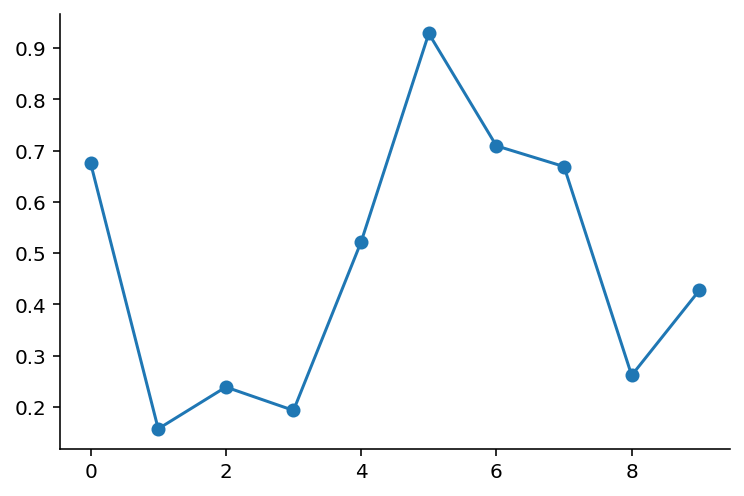

In [3]:
key = random.PRNGKey(45)  # for reproducibility
beta_draws = random.beta(key, a=1, b=1, shape=(10,))
plt.plot(beta_draws, marker="o")
sns.despine()

Now, we take this and begin our stick-breaking process. Because it is effectively a for-loop in which each loop iteration uses carryover from the previous loop iteration, I have written it taking advantage of JAX's `lax.scan` function.

In [4]:
def stick_breaking_weights(beta_draws):
    """Return weights from a stick breaking process.
    
    :param beta_draws: i.i.d draws from a Beta distribution.
        This should be a row vector.
    """
    def weighting(occupied_probability, beta_i):
        """
        :param occupied_probability: The cumulative occupied probability taken up.
        :param beta_i: Current value of beta to consider.
        """
        weight = (1 - occupied_probability) * beta_i
        return occupied_probability + weight, weight
    
    occupied_probability, weights = lax.scan(weighting, np.array(0.), beta_draws)
    
    weights = weights / np.sum(weights)
    return occupied_probability, weights

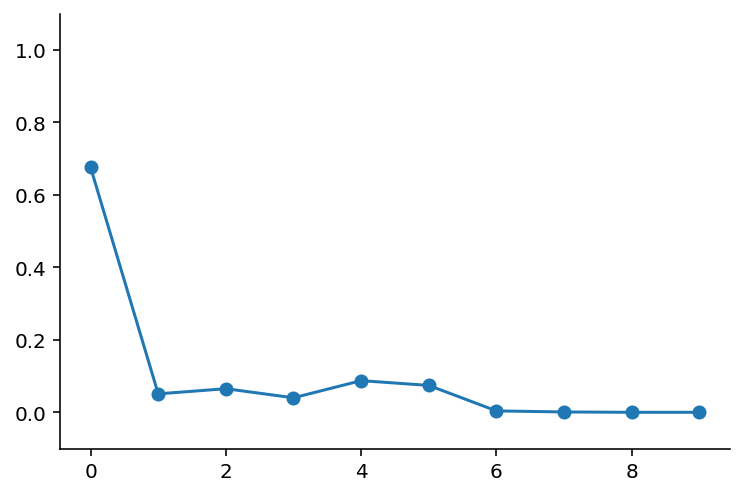

In [5]:
occupied_prob, weights = stick_breaking_weights(beta_draws)
plt.plot(weights, marker="o")
plt.ylim(-0.1, 1.1)
sns.despine()

Really cool! We now have a vector of weights, normalized to a probability distribution.

It's worth at this point exploring the effect of varying the $b$ parameter in the Beta distribution:

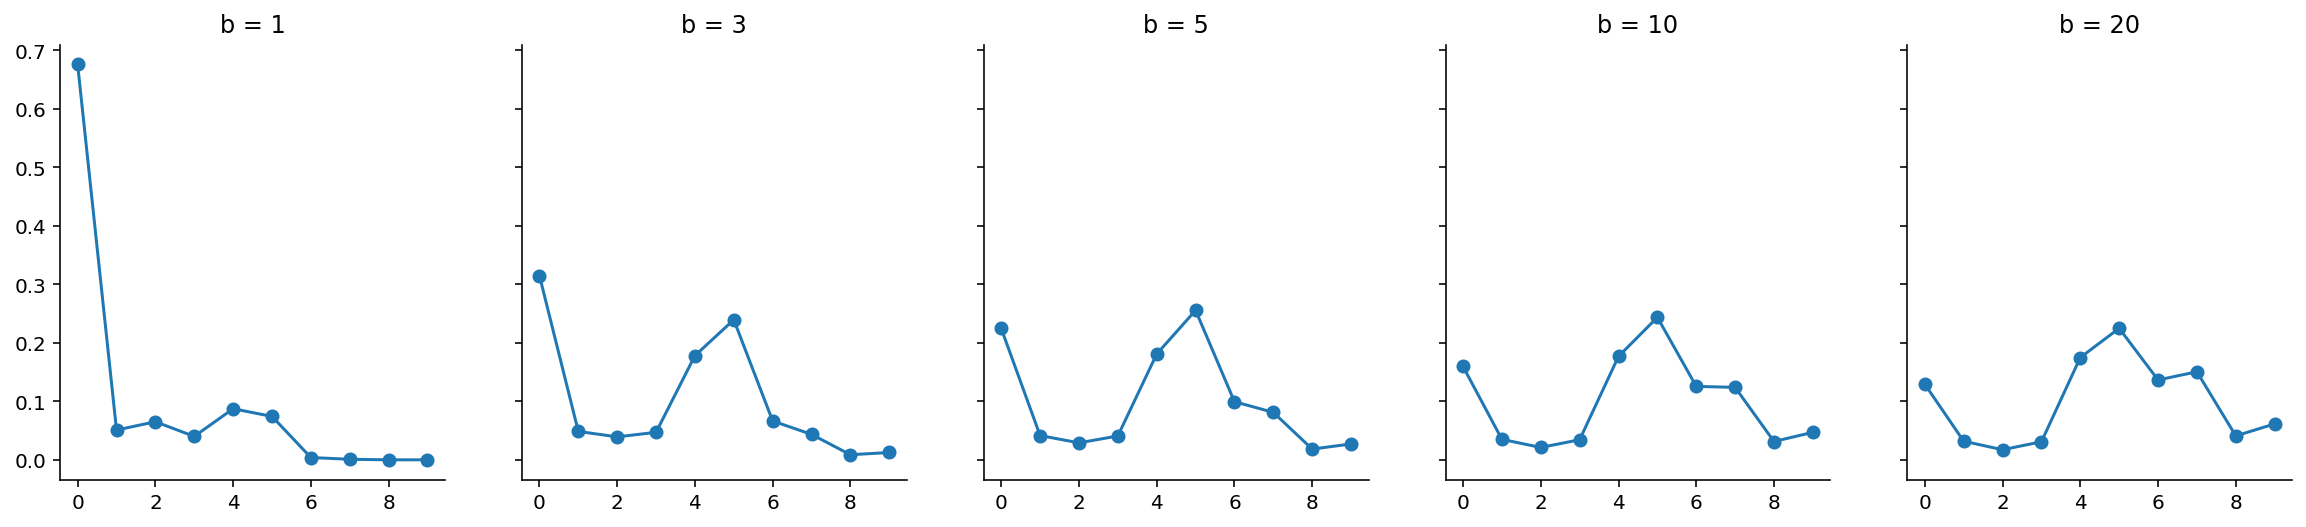

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4), sharey=True)

bvals = np.array([1, 3, 5, 10, 20])
beta_draws = vmap(partial(random.beta, key, 1, shape=(10,)))(bvals)
occupied_probs, weights = vmap(stick_breaking_weights)(beta_draws)

for ax, weight, bval in zip(axes, weights, bvals):
    ax.plot(weight, marker="o")
    ax.set_title(f"b = {bval}")
sns.despine()

As should be visible, when we increase the `b` value, we get a less concentrated and flatter distribution compared to when we use a smaller `b` value. Thus, `b` acts as a "concentration" parameter. Smaller values means probability mass is concentrated on a smaller number of slots, while larger values means probability mass is diffused across a larger number of slots.

How does this relate to transition matrices in hidden Markov models? Well, a potentially desirable property is that we wish to express is that most of the states tend to move into a certain smaller number of states, thereby _concentrating_ the number of occupied states into a smaller set. This is equivalent to concentrating the transition matrix to a subset of _columns_. Let's see how we can generate this kind of transition matrix.

Firstly, since transition matrices are square, let's start with a 15x15 transition matrix, i.e. one with 15 states. 

In [7]:
N_STATES = 15
CONCENTRATION = 2

beta_draws = random.beta(key, a=1, b=CONCENTRATION, shape=(N_STATES, N_STATES))

To visualize these i.i.d. Beta-distributed draws, let's use a heatmap.

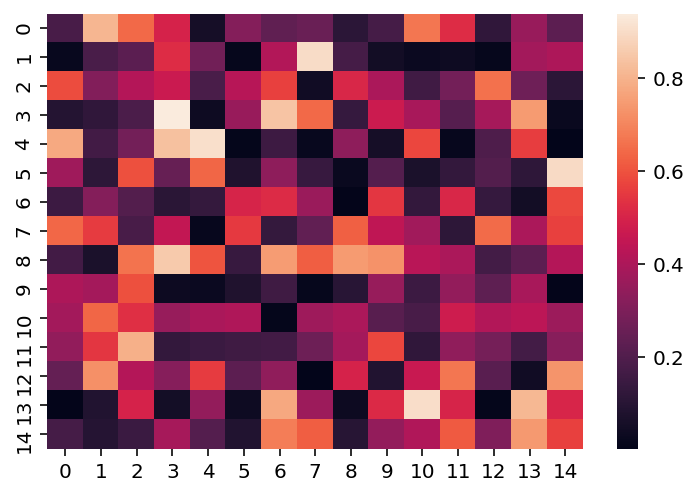

In [8]:
sns.heatmap(beta_draws);

Keep in mind, this is not the transition matrix just yet. It is the precursor to one!

Next up, on a row-wise basis, we convert each row to a weighting vector, thereby getting back a transition matrix:

In [9]:
def compute_transition_matrix(beta_draws):
    _, transition_matrix = vmap(stick_breaking_weights)(beta_draws)
    return _, transition_matrix

_, transition_matrix = compute_transition_matrix(beta_draws)

And visualizing the transition_matrix...

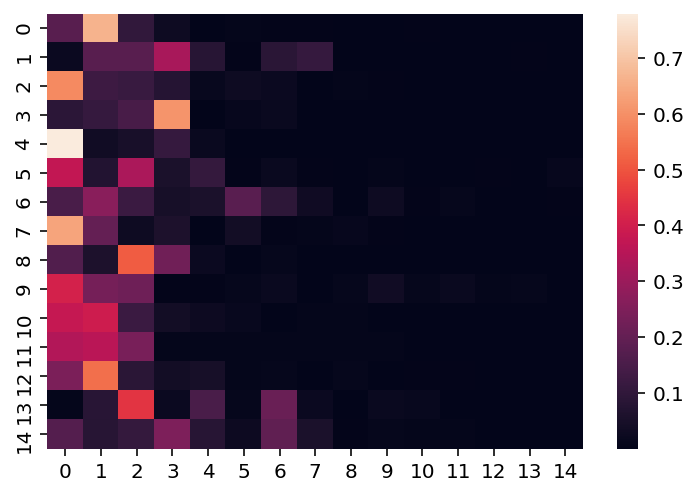

In [10]:
sns.heatmap(transition_matrix);

Voilà! We have a transition matrix that has most of the probability mass concentrated in just a few states. Let's calculate the equilibrium distribution:

In [11]:
def equilibrium_distribution(p_transition):
    n_states = p_transition.shape[0]
    A = np.append(
        arr=p_transition.T - np.eye(n_states),
        values=np.ones(n_states).reshape(1, -1),
        axis=0
    )
    # Moore-Penrose pseudoinverse = (A^TA)^{-1}A^T
    pinv = np.linalg.pinv(A)
    # Return last row
    return pinv.T[-1]

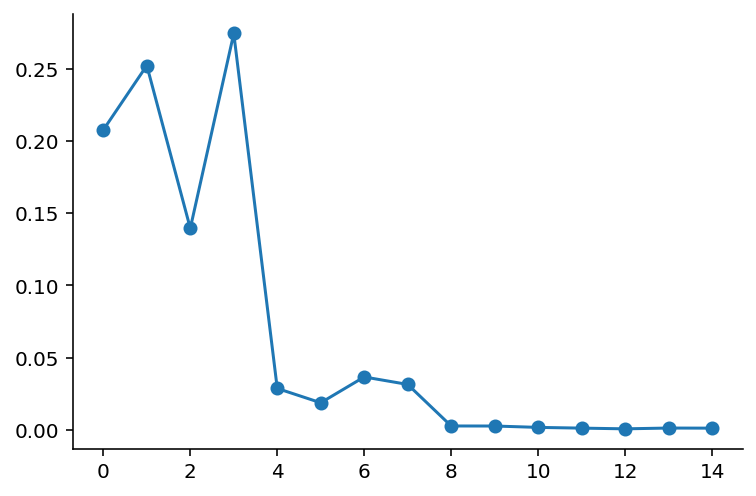

In [12]:
eq_distribution = equilibrium_distribution(transition_matrix)
plt.plot(eq_distribution, marker="o")
sns.despine()

As should be visible, we spend the majority of time in just a few states, and not too many more.

At this point, it's worth exploring how the "concentration" parameter affects the transition matrix, and hence the equilibrium distribution.

In [13]:
CONCENTRATIONS = np.array([1, 3, 5, 10, 20])
N_DIMS = 30
beta_draws = vmap(partial(random.beta, key, 1, shape=(N_DIMS, N_DIMS)))(CONCENTRATIONS)
beta_draws.shape

(5, 30, 30)

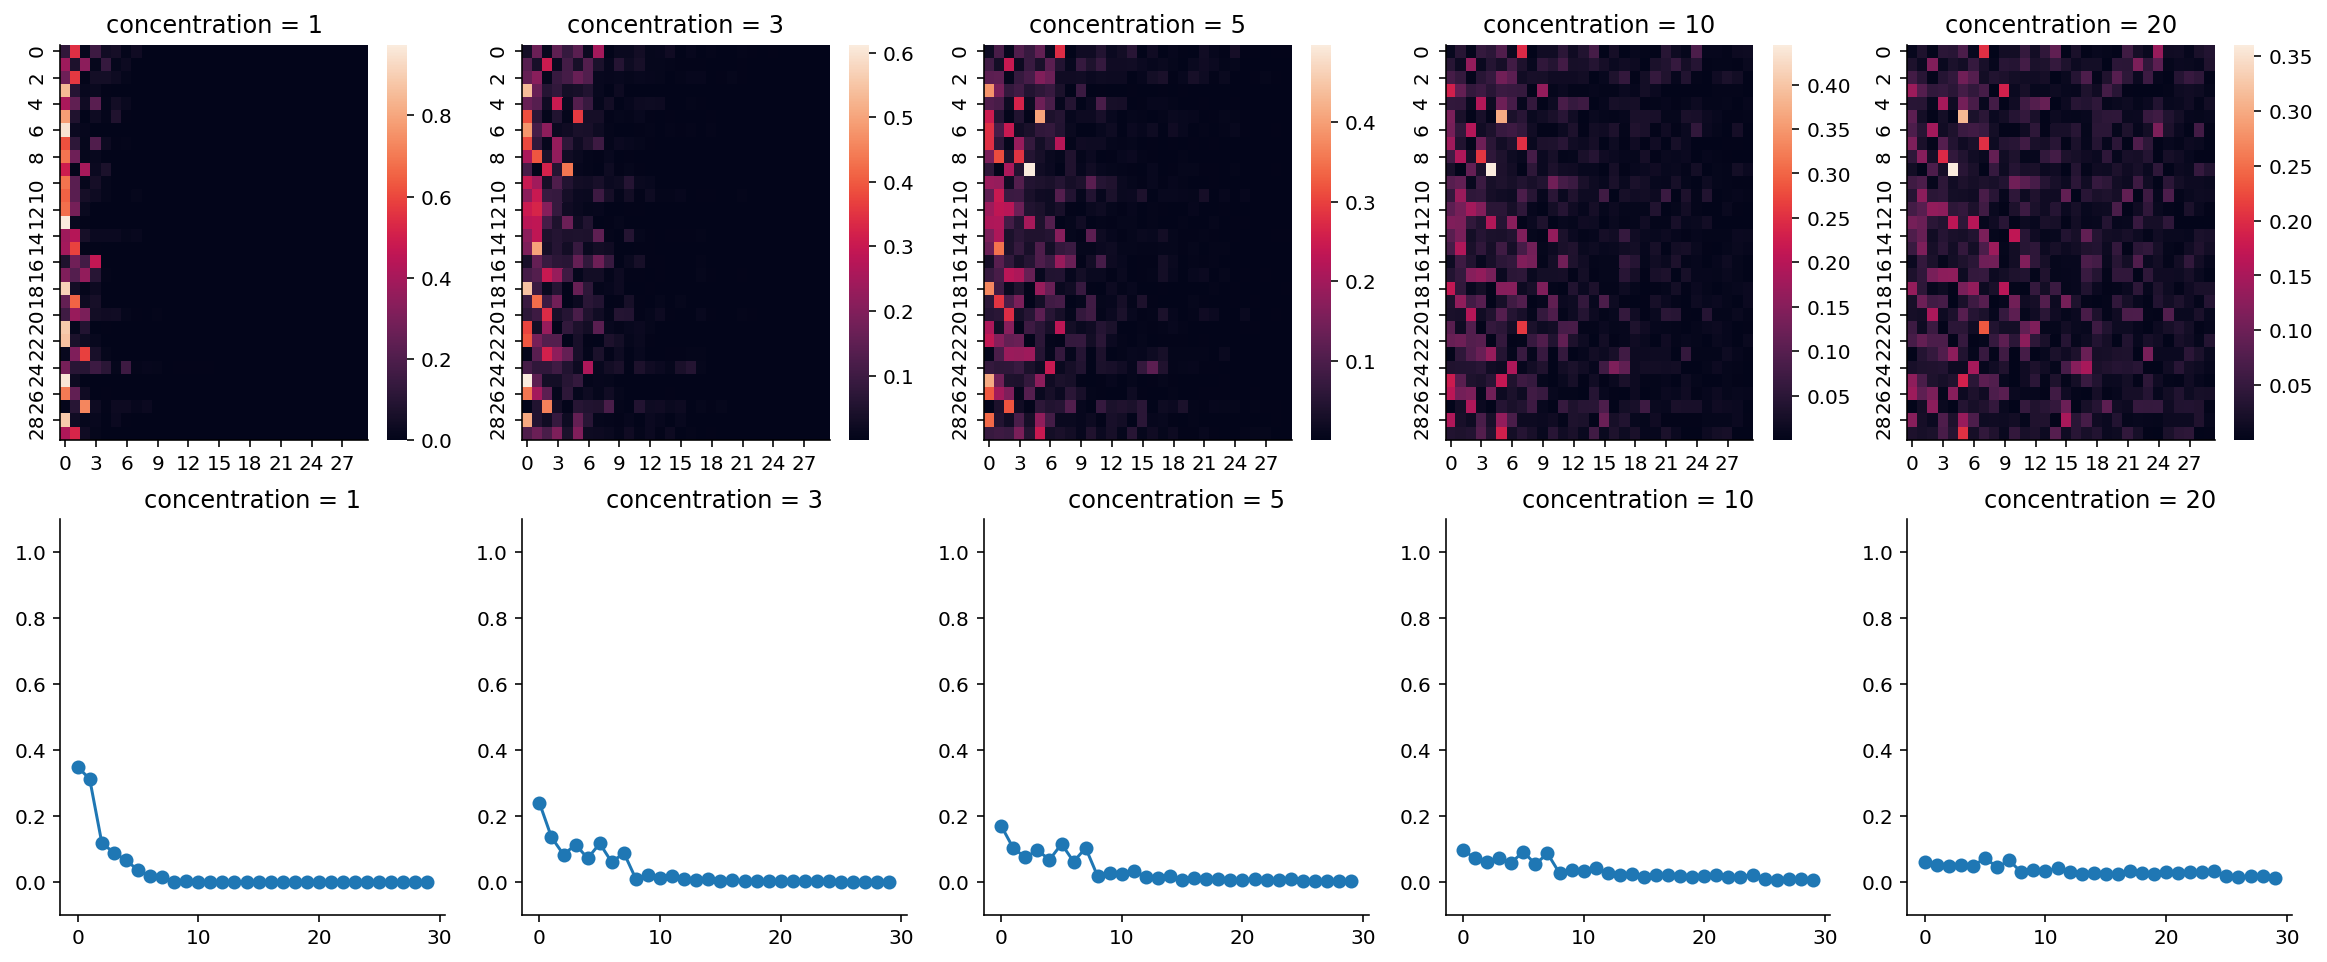

In [14]:
_, transition_matrices = vmap(compute_transition_matrix)(beta_draws)
eq_distributions = vmap(equilibrium_distribution)(transition_matrices)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

for ax, conc, tmat in zip(axes[0, :], CONCENTRATIONS, transition_matrices):
    sns.heatmap(tmat, ax=ax)
    ax.set_title(f"concentration = {conc}")
    
for ax, conc, eq_dist in zip(axes[1, :], CONCENTRATIONS, eq_distributions):
    ax.plot(eq_dist, marker="o")
    ax.set_title(f"concentration = {conc}")
    ax.set_ylim(-0.1, 1.1)
sns.despine()

As you can see, when the value of `b` goes up, the more diffuse the transition matrix, and the more evenly spread-out the equilibrium states will be.

## Let's generate Markov sequences now

Now that we know how to generate transition matrices, let's step back and try to see whether the generated Markovian sequences from these transition matrices make sense, i.e. whether they display the desired properties that we seek or not.

In [15]:
from jax import random
from jax.scipy.special import logit


Firstly, let's try writing the function that generates a Markov sequence given a transition matrix.

In [16]:
from typing import List
from jax import jit

def markov_sequence(key, p_transition: np.array, sequence_length: int) -> List[int]:
    """
    Generate a Markov sequence based on p_init and p_transition.
    
    Strategy: leverage categorical distribution.
    We need to vmap over split PRNGKeys, which will give us the desired number of draws.
    """
    p_eq = equilibrium_distribution(p_transition)
    logit_p_eq = logit(p_eq)
    initial_state = random.categorical(key, logits=logit_p_eq, shape=(1,))
    
    def draw_state(prev_state, key):
        logits = logit(p_transition[prev_state])
        state = random.categorical(key, logits=logits, shape=(1,))
        return state, state

    keys = random.split(key, sequence_length)
    final_state, states = lax.scan(draw_state, initial_state, keys)
    return final_state, np.squeeze(states)
    
markov_sequence = jit(markov_sequence, static_argnums=(2,))

final, sequence = markov_sequence(key, transition_matrices[0], 100)
final, sequence

(DeviceArray([0], dtype=int32),
 DeviceArray([0, 1, 2, 1, 0, 0, 3, 0, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1,
              2, 0, 0, 1, 0, 4, 1, 0, 7, 0, 1, 0, 1, 2, 0, 2, 4, 0, 0, 1,
              2, 1, 2, 1, 0, 1, 4, 5, 0, 1, 0, 5, 0, 1, 0, 1, 0, 1, 0, 1,
              2, 1, 1, 2, 0, 3, 0, 1, 1, 1, 4, 1, 4, 1, 2, 1, 0, 1, 2, 1,
              0, 3, 0, 1, 5, 0, 1, 2, 1, 0, 1, 0, 1, 0, 3, 0, 1, 0, 1, 0],            dtype=int32))

Now, I think we can generate a bunch of Markov chain sequences using `vmap`.

In [17]:
def markov_seq_vmappable(key, transition_matrix):
    sequence_length = 500
    return markov_sequence(key, transition_matrix, sequence_length)

_, sequences = vmap(markov_seq_vmappable)(random.split(key, 5), transition_matrices)

Let's plot them out!

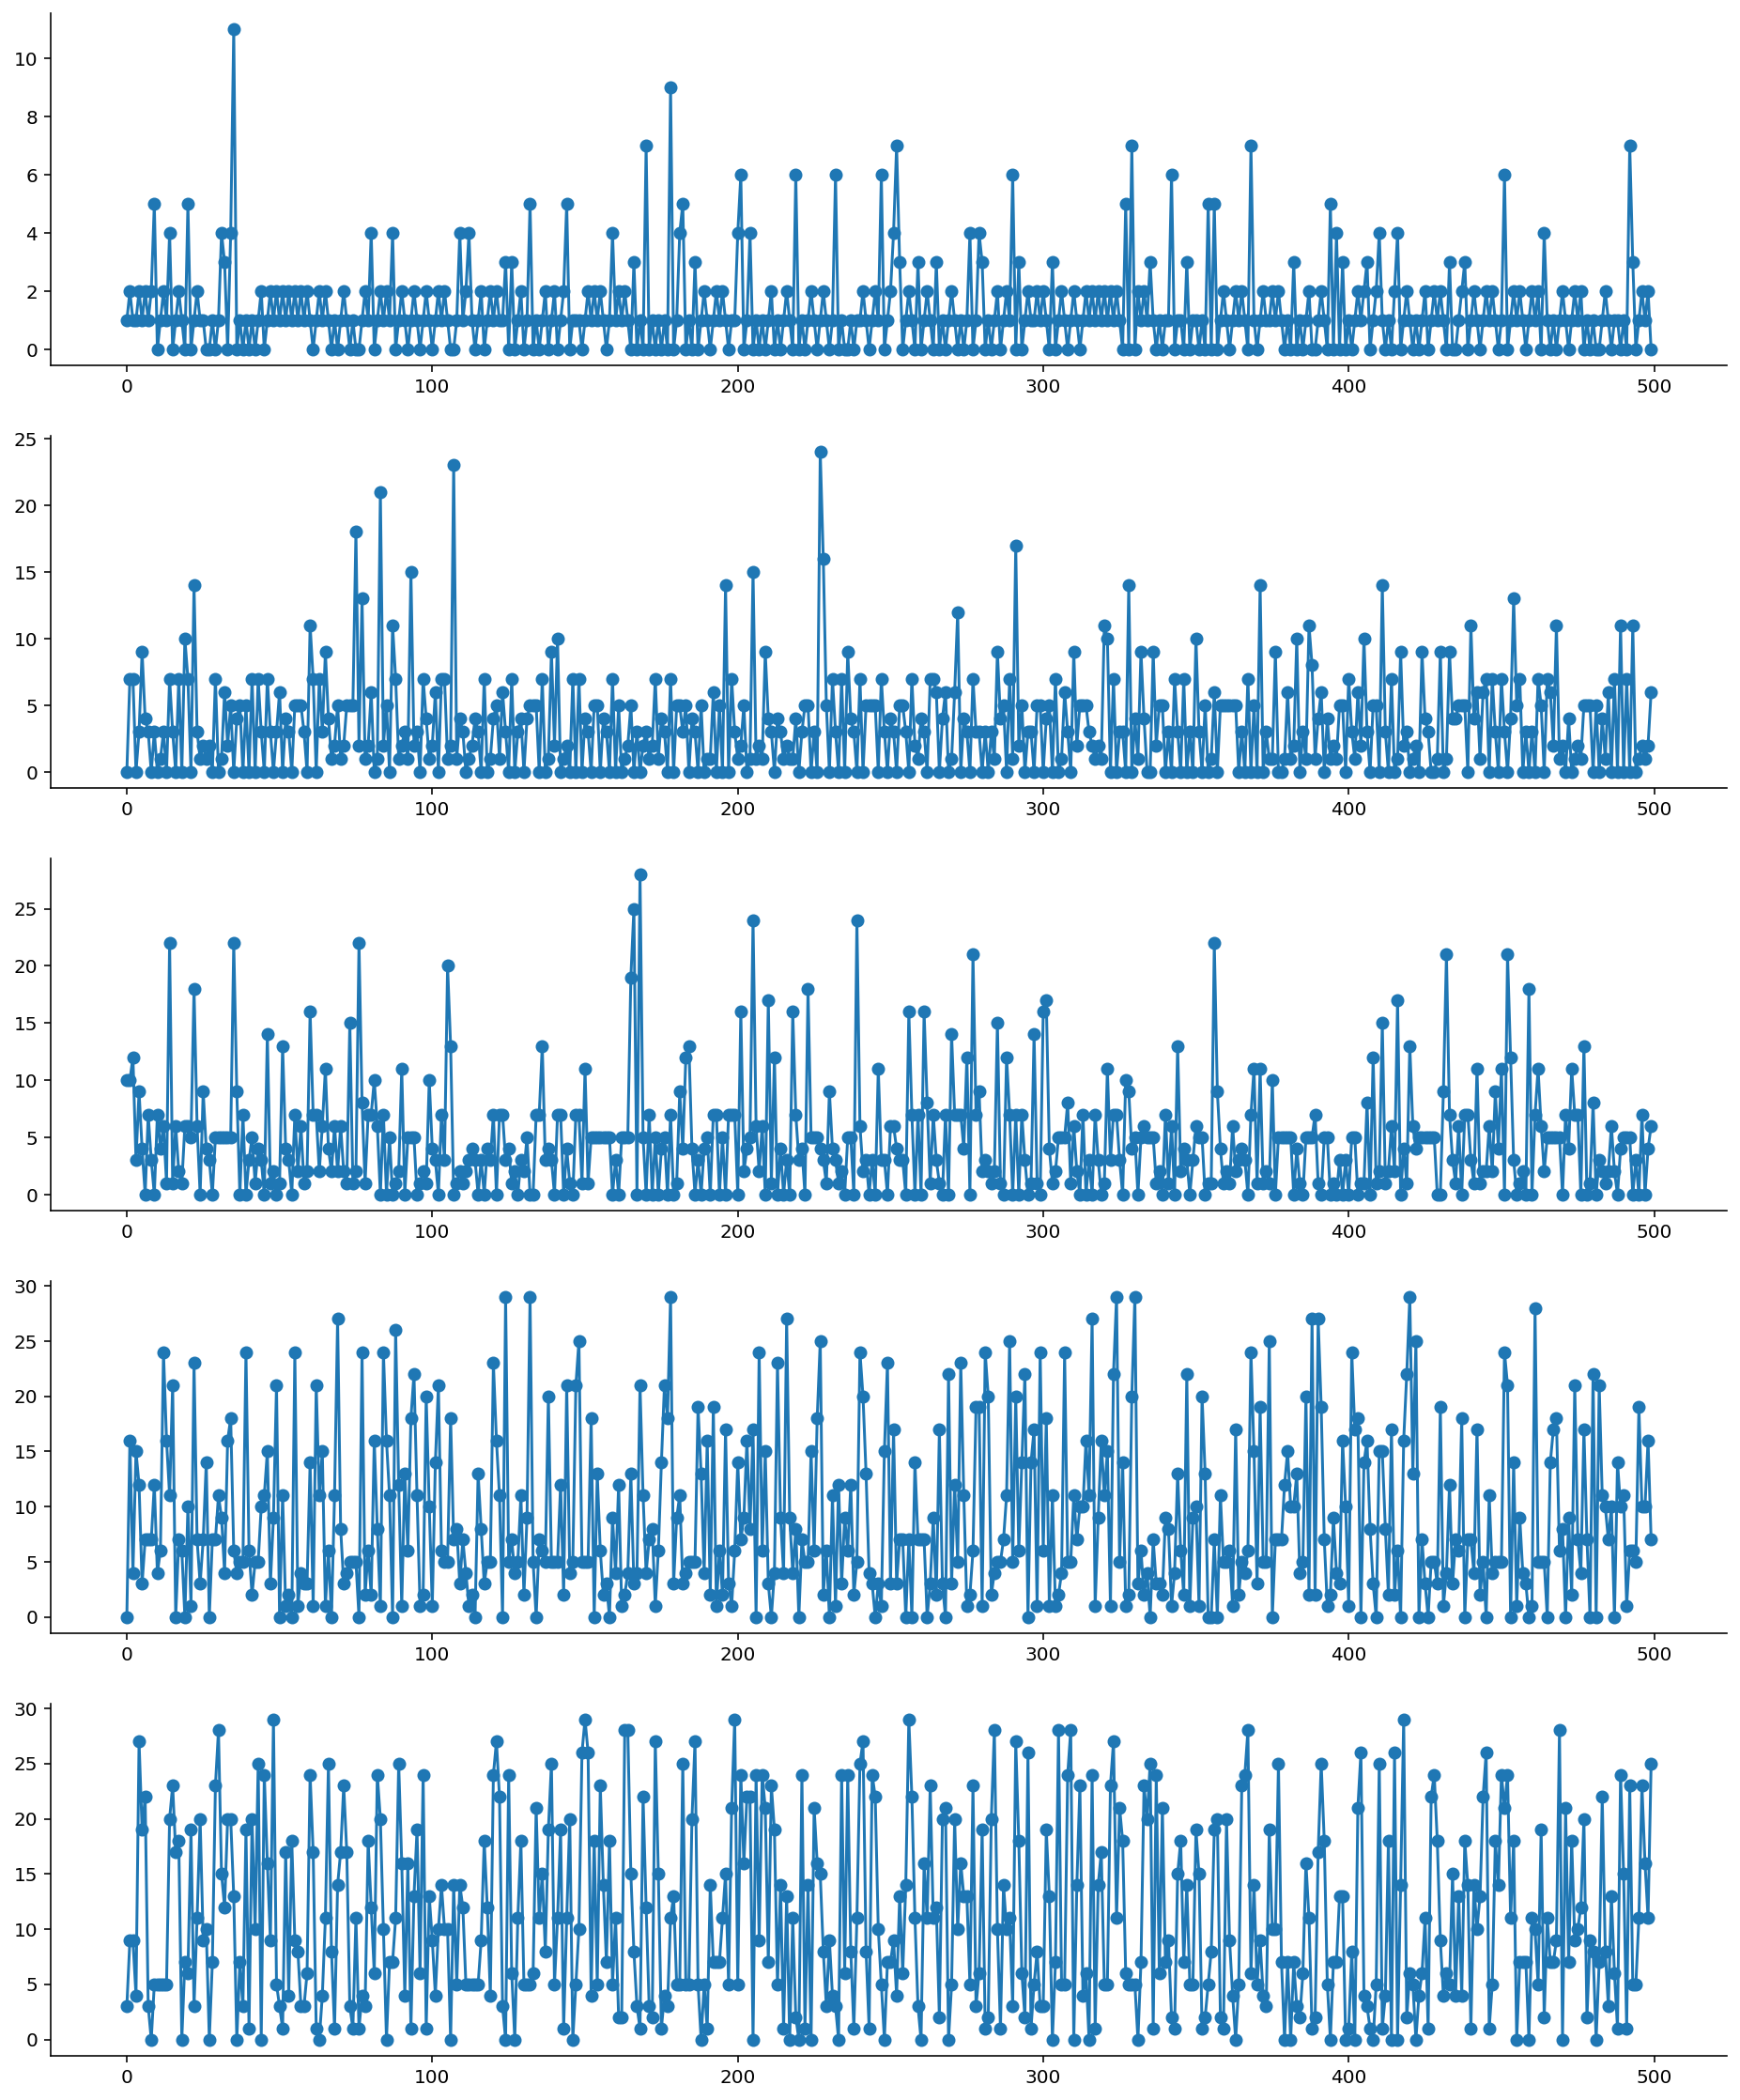

In [18]:
import seaborn as sns

fig, axes = plt.subplots(figsize=(16, 20), nrows=5, ncols=1)

for ax, seq in zip(axes, sequences):
    ax.plot(range(len(seq)), seq, marker="o")
sns.despine()

As should be visible, as we increase the concentration parameter (really, I think this should be renamed as a "diffusion" parameter),
the number of states that we would typically occupy increases. At smaller values of the concentration parameter, the number of states we would typically occupy decreases.

## Generating Markov sequences concentrated on a few stable states

We've thus far generated transition matrices that are biased towards a few states, but they do tend to be jumpy, as the above scatterplots show. In other words, we have not yet generated matrices that allow for _stability inside a state_. Stability inside a state is generated from strong diagonals. We can engineer this in the generation of the matrix by leveraging (once again) the Beta distribution. Specifically, the generative story here is that each row of the transition matrix is generated by stick-breaking, but the diagonals are replaced by a Beta draw that is biased towards high probabilities. Let's see this in action for one transition matrix.

In [19]:
def diagonal_draws(key, bias_factor, shape):
    return random.beta(key, a=bias_factor, b=1, shape=shape)

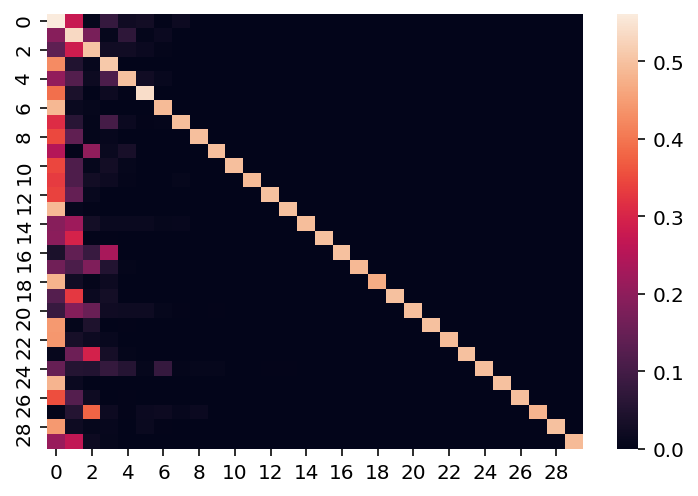

In [20]:
dd = diagonal_draws(key, bias_factor=50, shape=(N_DIMS,))
dom_diag_transition_matrix = transition_matrices[0] + np.diagflat(dd)

def normalize_prob_vect(v):
    return v / np.sum(v)


def normalize_transition_matrix(transition_matrix):
    return vmap(normalize_prob_vect)(transition_matrix)

dom_diag_transition_matrix = normalize_transition_matrix(dom_diag_transition_matrix)
sns.heatmap(dom_diag_transition_matrix);

Now given _this_ transition matrix, let's generate new sequences:

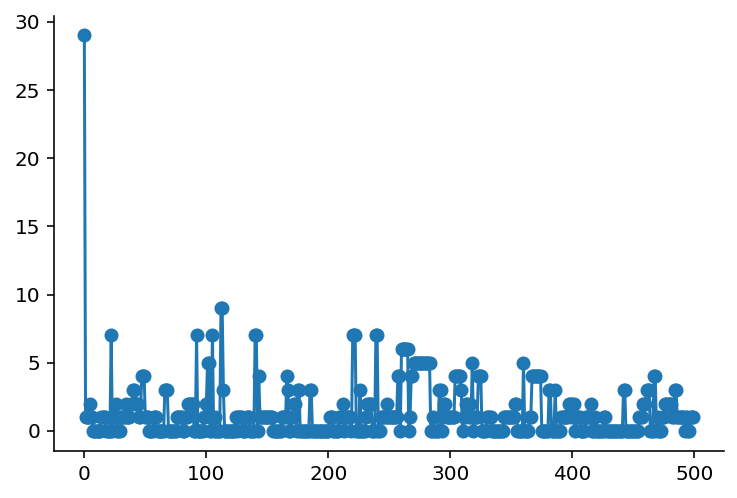

In [21]:
_, seq = markov_sequence(key, dom_diag_transition_matrix, 500)
plt.plot(seq, marker="o")
sns.despine()

As is visible from the plot above, we get sequences that tend to stay inside a state, and when they do venture out to unfavoured states (e.g. state 5), they quickly return back to a favoured state.

Now, let's see what kind of sequences we get when we use the same dominant diagonal with different concentration parameters.

Firstly, we generate a bunch of dominant diagonal matrices:

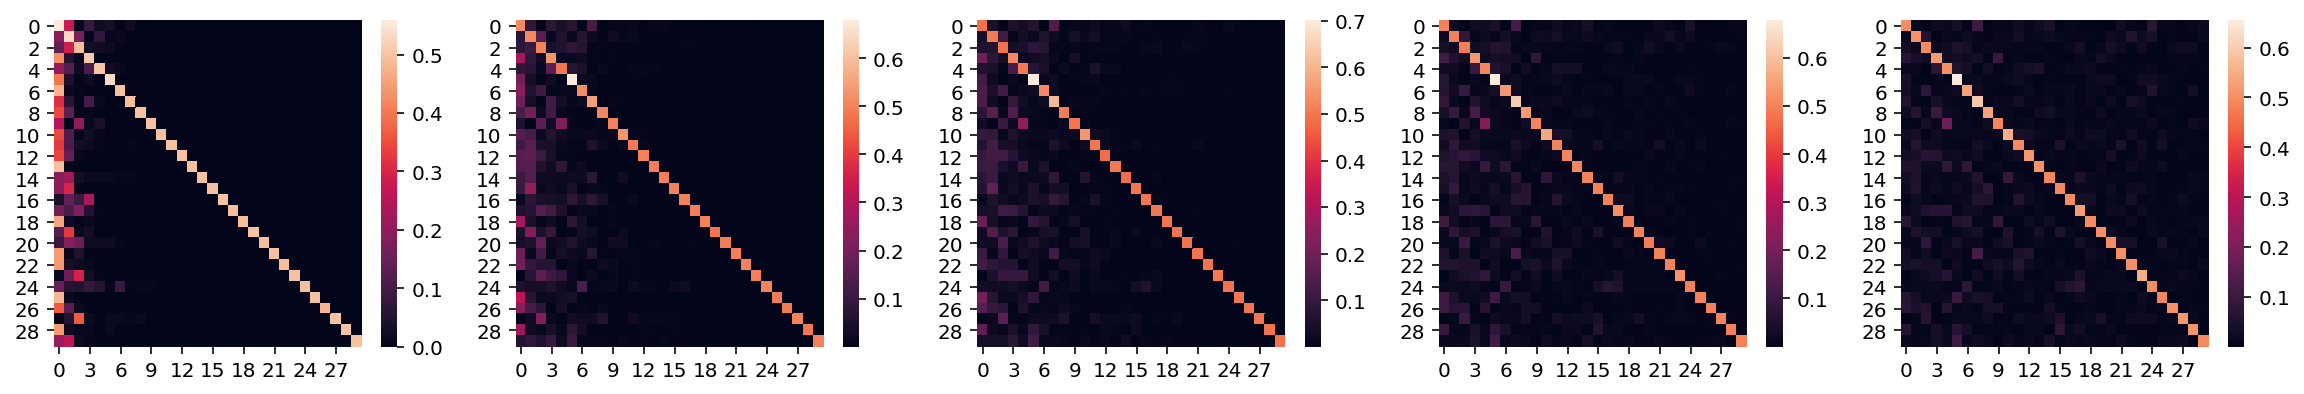

In [22]:
keys = random.split(key, 5)
diagonals = vmap(partial(diagonal_draws, bias_factor=50, shape=(N_DIMS,)))(keys)

def create_dominant_diagonal(p_transition, diagonal):
    p_transition = p_transition + np.diagflat(diagonal)
    return normalize_transition_matrix(p_transition)

dom_diag_transition_matrices = vmap(create_dominant_diagonal)(transition_matrices, diagonals)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 3))

for ax, mat in zip(axes, dom_diag_transition_matrices):
    sns.heatmap(mat, ax=ax)

Now, we generate a bunch of sequences.

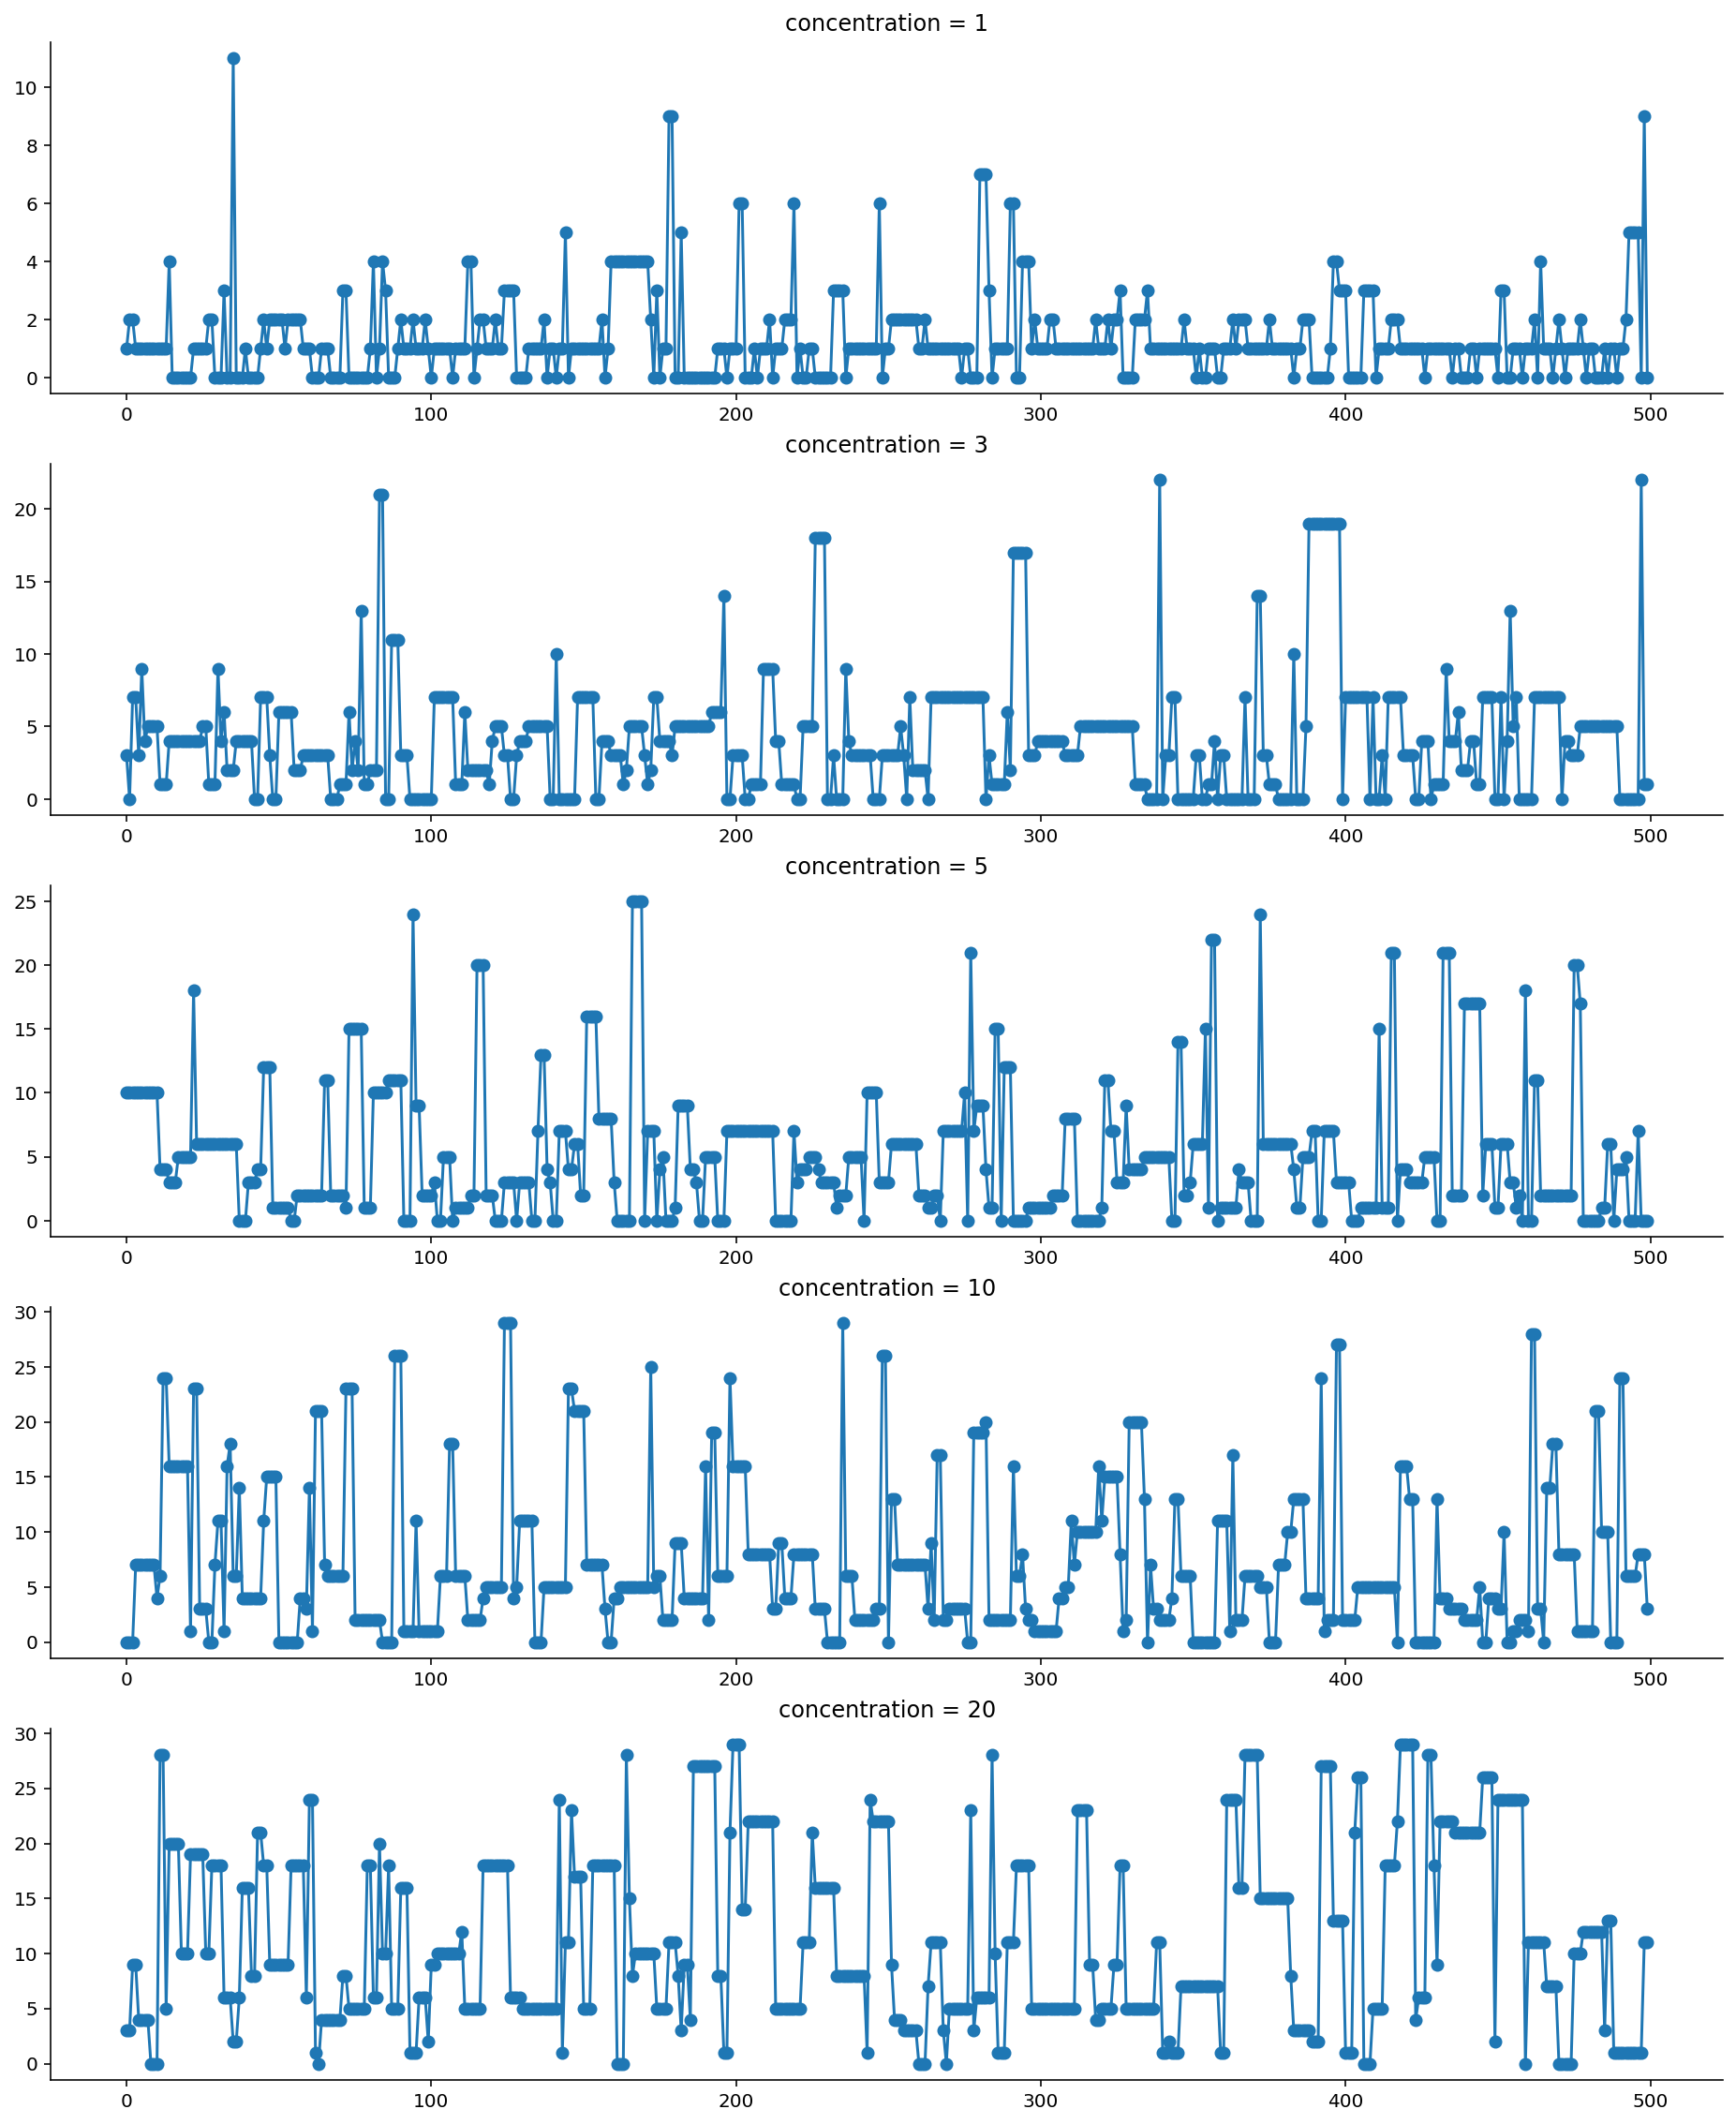

In [23]:
_, sequences = vmap(markov_seq_vmappable)(random.split(key, 5), dom_diag_transition_matrices)

fig, axes = plt.subplots(figsize=(16, 20), nrows=5, ncols=1)

for ax, seq, conc in zip(axes, sequences, CONCENTRATIONS):
    ax.plot(range(len(seq)), seq, marker="o")
    ax.set_title(f"concentration = {conc}")
sns.despine()

As should be visible from here, we now generate sequences that have a much higher propensity to stay within their own state, rather than jump around. Additionally, when there are more states "available" (i.e. concentration runs higher), we also see them stay within their own state rather than jump back down to the favoured states.

## Inference of the right "concentration" of states

Given the transition matrix, can we infer the concentration parameter that best describes it? This is what we're going to try out here.

We start with a vanilla transition matrix generated from a `concentration = 1` setting, with no dominant diagonals. This is the easier setting to begin with:

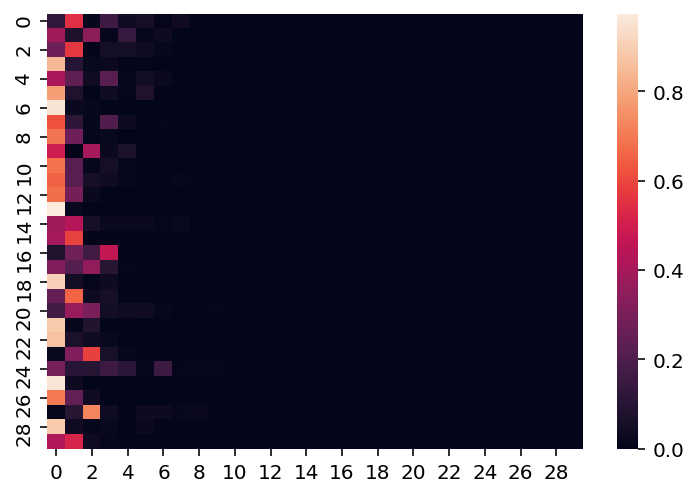

In [24]:
sns.heatmap(transition_matrices[0]);

Each row of the transition matrix is generated by running a stick breaking process forward from Beta distributed draws. We can run the process backwards to get back our Beta-distributed matrix. Because there's division involved, I have opted to operate in logarithmic space instead, to avoid over/under-flow issues.

In [25]:
from jax import lax
def beta_draw_from_weights(weights):
    def beta_from_w(accounted_probability, weights_i):
        """
        :param accounted_probability: The cumulative probability acounted for.
        :param weights_i: Current value of weights to consider.
        """
        denominator = 1 - accounted_probability
        log_denominator = np.log(denominator)
        
        log_beta_i = np.log(weights_i) - log_denominator

        newly_accounted_probability = accounted_probability + weights_i
        
        return newly_accounted_probability, np.exp(log_beta_i)
    final, betas = lax.scan(beta_from_w, np.array(0.), weights)
    return final, betas

And now, to sanity-check that it works:

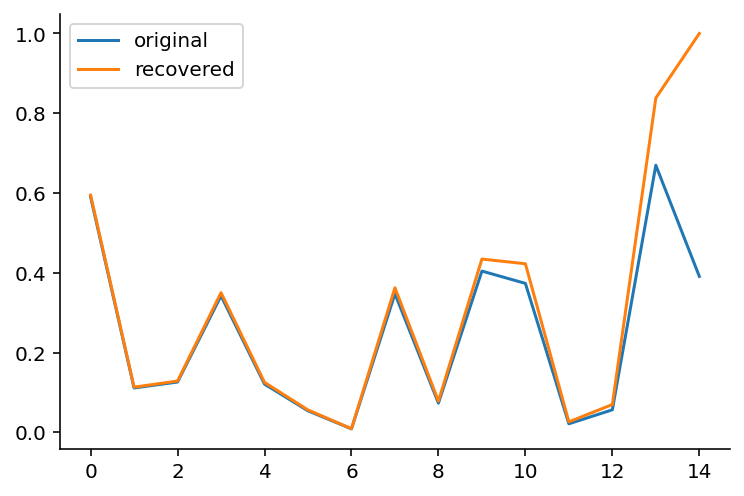

In [26]:
beta_draw = random.beta(key, a=1, b=3, shape=(15,))
_, weights = stick_breaking_weights(beta_draw)
_, beta_draw_hat = beta_draw_from_weights(weights)
plt.plot(beta_draw, label="original")
plt.plot(beta_draw_hat, label="recovered")
plt.legend()
sns.despine()

Up till the last few values, we are basically able to recover the beta distributed draw that generated the matrix. The fundamental problem we're facing here is that when we are faced with a probability vector, we're still missing the "last stick" which would give us an accurate estimate of the originals. As such, only the first few are really accurate, and the accuracy of beta draw recovery goes down as we go across the vector.

Let's now apply the function to every row in the transition matrix.

In [27]:
def recover_beta(transition_matrix):
    return vmap(beta_draw_from_weights)(transition_matrix)

<AxesSubplot:>

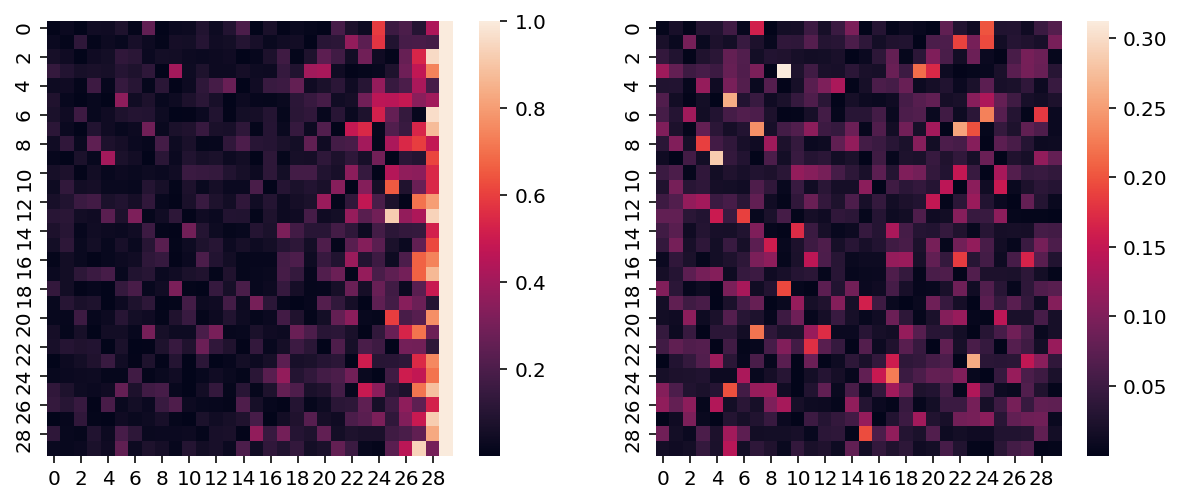

In [28]:
_, recovered_betas = vmap(recover_beta)(transition_matrices)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

idx = 4
sns.heatmap(recovered_betas[idx], ax=axes[0])
sns.heatmap(beta_draws[idx], ax=axes[1])

Matches what we saw above - we're doing an almost-OK job here.

Now, we can evaluate the logpdf of the matrix.
Because each entry in the recovered betas matrix is an i.i.d. draw from the Beta distribution,
and because row-wise the first 3-5 elements are accurately estimatable backwards from the weights,
we will estimate the concentration parameter using only the first three columns of betas from the matrix.

Test-driving the syntax below...

In [29]:
np.sum(stats.beta.logpdf(recovered_betas[4, :, :3], a=1, b=9))

DeviceArray(153.58743, dtype=float32)

Looks good! Let's now define a function for the logpdf.

In [30]:
def transition_matrix_logpdf(transition_matrix, concentration, num_cols=2):
    _, beta_recovered = recover_beta(transition_matrix)
    logp = stats.beta.logpdf(beta_recovered[:, :num_cols], a=1, b=concentration)
    return np.sum(logp)

transition_matrix_logpdf(transition_matrices[1], 5)

DeviceArray(20.504543, dtype=float32)

Just to see if this is a gradient optimizable problem, let's plot a range of concentration values, and see what happens.

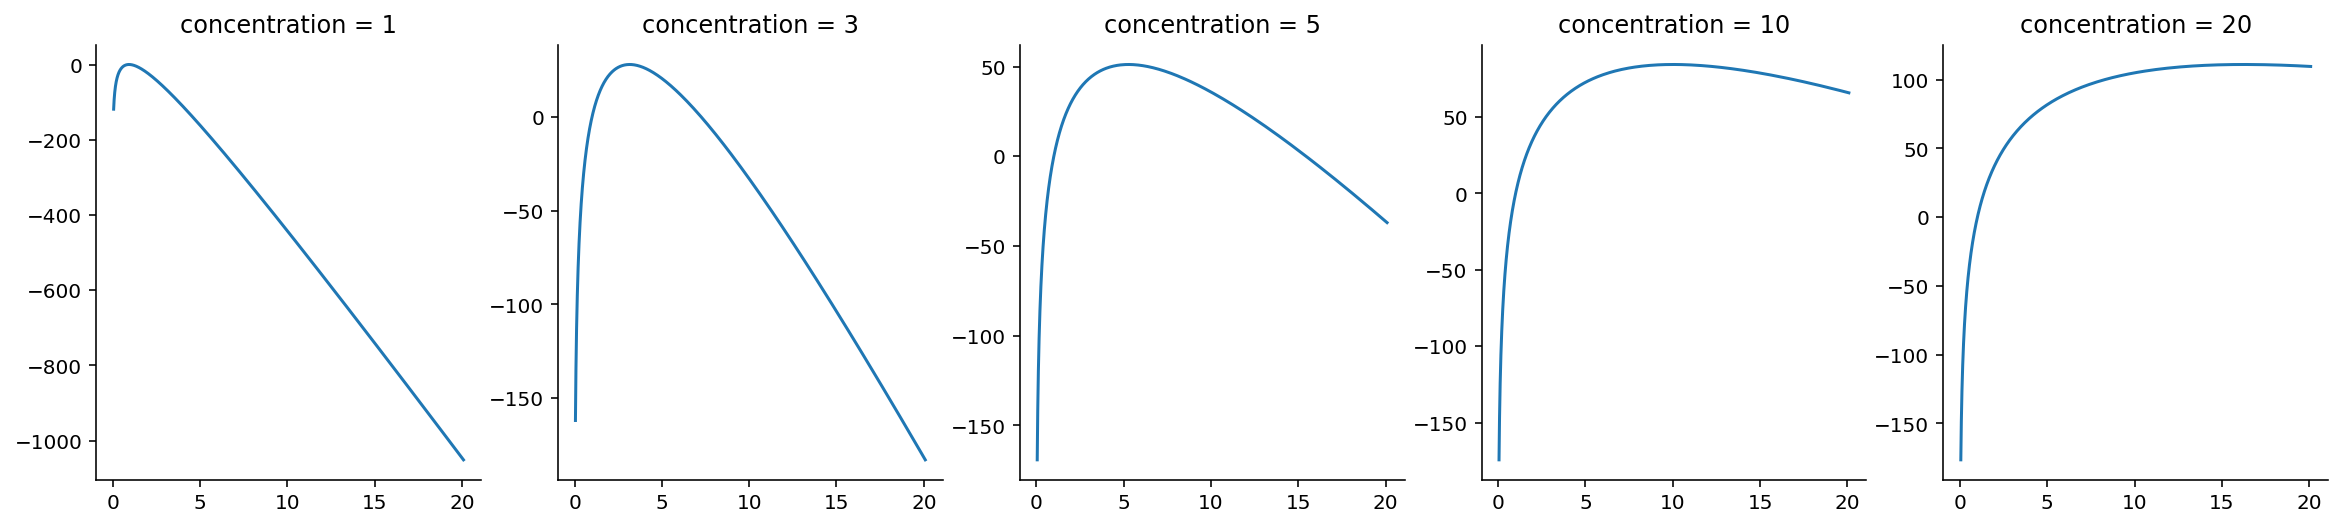

In [31]:
log_conc_range = np.linspace(-3, 3, 10000)
conc_range = np.exp(log_conc_range)

def loglike_range(transition_matrix, log_conc_range):
    conc_range = np.exp(log_conc_range)
    ll = vmap(partial(transition_matrix_logpdf, transition_matrix))(conc_range)
    return ll

ll = loglike_range(transition_matrices[0], log_conc_range)

lls = vmap(partial(loglike_range, log_conc_range=log_conc_range))(transition_matrices)

fig, axes = plt.subplots(nrows=1, ncols=len(CONCENTRATIONS), figsize=(20, 4))

for ll, conc, ax in zip(lls, CONCENTRATIONS, axes):
    ax.plot(conc_range, ll)
    ax.set_title(f"concentration = {conc}")
sns.despine()

Not bad! Visually, it appears that we do pretty good in recovering the maximum likelihood value for most of the entries, but for concentration = 20, it's more difficult to do so.

Let's confirm by extracting the concentration at which we have maximum log-likelihood.

In [32]:
maxes = vmap(np.argmax)(lls)
mle_estimates = np.take(conc_range, maxes)
mle_estimates

DeviceArray([ 0.93080336,  3.1544516 ,  5.2786283 , 10.007456  ,
             16.251398  ], dtype=float32)

Great! Doing this brute-force is all nice and good, but one of the points of JAX is that we get to do gradient descent easily. So now, let's try to perform gradient-based optimization :).

We start by first defining a loss as a function of the log of the concentration. (We use the log so that when we do gradient optimization, we can be in an unbounded space.) We also define the gradient of the loss function.

In [33]:
def loglike_loss(log_concentration, transition_matrix):
    concentration = np.exp(log_concentration)
    ll = transition_matrix_logpdf(transition_matrix, concentration)
    return -ll

loglike_loss = jit(loglike_loss)
dloglike_loss = grad(loglike_loss)

Next up, we do the loop. Instead of writing an explicit for-loop, we are going to some JAX trickery here:

1. We write the loop taking advantage of `lax.scan`, which allows us to leverage the previous state to get back parameters to optimize.
1. We also vmap our training loop over all 5 matrices, starting with the same log concentration starting point. This allows us to essentially train five models at one shot. (I could have `pmap`-ed it, but I really only have one CPU and one GPU on my computer.)
1. Since the result is a vmapped, we have a collection of final states and historical states (which we can post-process post-hoc). Hence, we can vmap `get_params` over final states to get back the vector of final states (from a constant initial state).

In [34]:
from jax.experimental.optimizers import adam

init, update, get_params = adam(0.05)
log_conc_start = random.normal(key)

def step(prev_state, i, data, dloss):
    """One step in the training loop."""
    params = get_params(prev_state)
    g = dloss(params, data)
    state = update(i, g, prev_state)
    return state, state

def train(transition_matrix, dloss, params, n_steps=200):
    """The training loop for one transition matrix."""
    stepfunc = partial(step, data=transition_matrix, dloss=dloss)
    stepfunc = jit(stepfunc)

    state = init(params)
    final_state, states = lax.scan(stepfunc, state, np.arange(n_steps))
    return final_state, states

trainfunc = partial(train, params=log_conc_start, dloss=dloglike_loss)
trainfunc = jit(trainfunc)
# Train across all transition matrices!
final_states, states_history = vmap(trainfunc)(transition_matrices)
np.exp(vmap(get_params)(final_states))

DeviceArray([ 0.93007433,  3.1553512 ,  5.277723  , 10.022267  ,
             16.264425  ], dtype=float32)

We can also get the history by `vmap`-ing `get_params` over `all_states`.

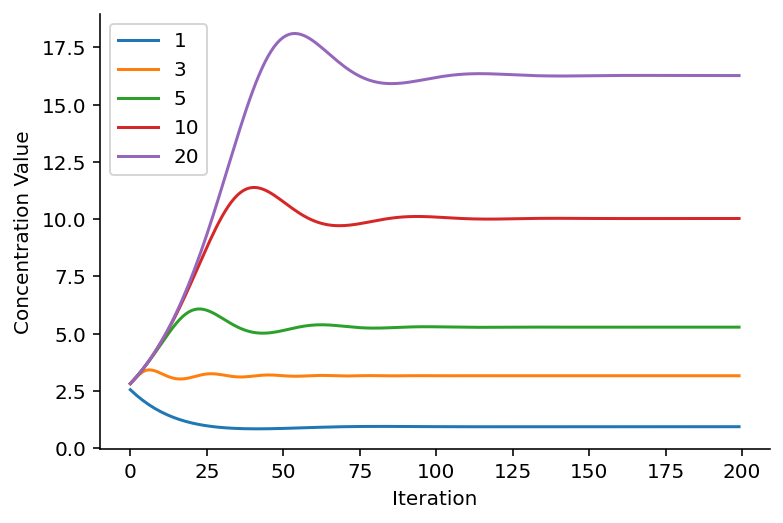

In [35]:
log_concentration_history = vmap(get_params)(states_history)

for concentration, history in zip(CONCENTRATIONS, log_concentration_history):
    plt.plot(np.exp(history), label=concentration)
plt.xlabel("Iteration")
plt.ylabel("Concentration Value")
plt.legend()
sns.despine()

Now, if you're wondering how I knew 200 steps would be sufficient for convergence _a priori_, I didn't :). I had originally tried 1000 steps before staring at the concentration curves, at which point I then knew 200 was sufficient. So... no magic there.

## Summary

This was a bit of a whirlwind tour of a notebook, in that there were many concepts and ideas tied together into one "project". 

With respect to HMMs, it's super important to have a proper mental model of each of its components. In the case of _expressing_ the idea that we have a restricted number of states, we may _engineer_ this into the model by taking advantage of column-wise heaviness in a restricted subset of states. This is mathematically most naturally incorporated by composint together row-wise Dirichlet-distributed probability arrays. We can also mathematically _engineer_ consistency in states by taking advantage of high Beta-distributed values. Compose the two together, and we get a transition matrix that favours entry into a small number of states with stability in there.

Beyond that lesson, we saw the power of composable programs using JAX. `vmap`, `jit`, `lax.scan`, and more from the JAX toolkit gives us the ability to write performant programs that sort of "just make sense", once you know what their idioms are. Specifically:

- `vmap` is a vanilla for-loop, processing an elementary function over an axis of an array.
- `lax.scan` is a carry-over for-loop, processing the result of a previous iteration, with accumulation of history as well.
- `jit` gives you just-in-time compilation of a function.
- `grad` gives you gradients of any arbitrary function written in a JAX-compatible, pure functional fashion.

In particular, getting used to the `lax.scan` idioms has been a literal door-opener. We can now write really performant loops that use results from previous iterations, such as a gradient descent training loop or an MCMC sampler. Using `lax.scan`, we wrote:

- A Markov chain state generator
- A generator of Dirichlet-distributed weights from i.i.d. Beta distribution draws
- A reverse generator/estimator of Beta distribution draws from Dirichlet-distributed weights (with some inaccuracies of course, due to a lack of information).
- A fully-compiled gradient descent training loop that ran extremely fast.

And using `vmap`, we were able to do all sorts of vanilla loops, but the one I want to highlight is our ability to `vmap` the compiled training loop across multiple transition matrices. The fact that this _actually_ works never has left me in awe. Props to the JAX team here! Opens the door to `vmap`-ing training loops across random starting points (i.e. a split PRNGKey, much like what we did in the HMM state generator).

The trade-off is that we don't get nice progress bars, of course, which require that we break out of the compiled loop to show the current state. But the compilation speedups provided the opportunity to build our compiled tensor program end-to-end. We could verify first that things ran correctly on a moderately-sized number of iterations, before finally estimating how long we would need to go until convergence and letting the program run on its own. I'm sure this little change isn't too hard to adapt to, but will give you access to a whole new world of differential tensor programming that is just _cool_!